<a href="https://colab.research.google.com/github/sborah53/Machine-Learning-for-Physical-Sciences/blob/main/MLPS_Kernel_Tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theory

**This notebook was created by Sangkha Borah, IIT Hyderabad**


In this notebook we consider a one‑dimensional **double‑well** potential of the form  
$$
V(x) = a x^4 - b x^2,
$$
with $a > 0$ and $b > 0$, which produces two minima symmetrically located about the origin. Such double‑well potentials appear in many areas of physics, for example as toy models of symmetry breaking, Landau free energies, or effective potentials for bistable systems. We assume that the “true” potential is known analytically, but in practice we only have access to noisy samples $(x_i, y_i)$, where
$$
y_i = V(x_i) + \varepsilon_i,\quad \varepsilon_i \sim {N}(0,\sigma^2),
$$
representing experimental or numerical noise.

The **learning task** is: given noisy samples of $V(x)$ at a discrete set of positions $\{x_i\}_{i=1}^n$, reconstruct a smooth approximation of the underlying potential over a continuous domain. This is a supervised regression problem: inputs are positions $x \in \mathbb{R}$, outputs are scalar energies $V(x) \in \mathbb{R}$. A good regressor should denoise the observations, capture the double‑well structure, and extrapolate sensibly in regions where data are sparse.


**Kernel methods** provide a way to perform nonlinear regression by implicitly mapping inputs $x$ into a high‑dimensional feature space ${H}$, where linear methods can be applied. Instead of explicitly constructing basis functions $\phi(x)$, one specifies a **kernel function**
$$
k(x,x') = \langle \phi(x), \phi(x') \rangle_{{H}},
$$
which computes inner products in feature space directly from the original inputs.

A widely used choice is the **radial basis function (RBF)** or Gaussian kernel,
$$
k(x,x') = \exp\big(-\gamma \|x - x'\|^2\big),
$$
where $\gamma$ controls the effective length scale of the kernel (roughly, how rapidly correlations decay in input space). In one dimension this kernel corresponds to a superposition of Gaussian “bumps” centered at training points; the learned function can be viewed as a weighted sum of these localized basis functions.

Given training inputs $X = (x_1,\dots,x_n)$, the **Gram matrix** (kernel matrix) $K \in \mathbb{R}^{n\times n}$ is defined by
$$
K_{ij} = k(x_i, x_j).\,
$$
This matrix encodes pairwise similarities of the training samples in feature space and plays a central role in both support vector machines (SVM) and kernel ridge regression (KRR).


Support vector machines were originally formulated for binary classification, where the goal is to find a hyperplane in feature space that maximizes the margin between two classes. In the **hard‑margin** case with linearly separable data, the primal optimization problem is
$$
\min_{w,b} \frac{1}{2}\|w\|^2 \quad \text{s.t.}\quad y_i(\langle w, \phi(x_i)\rangle + b) \geq 1,\; i=1,\dots,n,
$$
with labels $y_i \in \{+1,-1\}$. Introducing Lagrange multipliers and solving the dual yields the classical **kernel SVM** solution
$$
f(x) = \sum_{i=1}^n \alpha_i y_i k(x_i,x) + b,
$$
where $\alpha_i$ are dual variables and only a subset of the training points (the support vectors) have nonzero weights.

For noisy or nonseparable data, **soft‑margin SVM** adds slack variables and a regularization parameter $C$ trading off margin size and classification error. The key conceptual ingredients that carry over to regression are:
- Representer theorem: the optimal solution lies in the span of kernel evaluations at training points.
- Regularization via the norm $\|w\|^2$ in feature space, controlling model complexity.
- Dual formulation in terms of the Gram matrix $K$.

In **support vector regression (SVR)**, one modifies the loss to an $\varepsilon$-insensitive tube around the target values, again obtaining a solution of the form
$$
f(x) = \sum_{i=1}^n (\alpha_i - \alpha_i^*) k(x_i, x) + b,
$$
with coefficients constrained by box constraints linked to $C$.


Kernel ridge regression combines the kernel machinery with a squared‑error loss and Tikhonov regularization. In feature space, KRR solves
$$
\min_{f \in {H}} \sum_{i=1}^n \big(f(x_i) - y_i\big)^2 + \lambda \|f\|_{{H}}^2,
$$
where $\lambda > 0$ is a regularization parameter. By the representer theorem,
$$
f(x) = \sum_{i=1}^n \alpha_i k(x_i, x),
$$
for some coefficients $\alpha \in \mathbb{R}^n$. Substituting this ansatz and minimizing over $\alpha$ yields the closed‑form **dual solution**
$$
(K + \lambda I_n)\,\alpha = y,
$$
where $K$ is the Gram matrix, $I_n$ is the $n\times n$ identity matrix, and $y = (y_1,\dots,y_n)^\top$. The predicted value at a new point $x$ is then
$$
\hat{y}(x) = f(x) = \sum_{i=1}^n \alpha_i k(x_i,x).\,
$$

In this sense, KRR can be viewed as an SVM‑style kernel method for regression, but with a quadratic loss and an $\ell_2$ penalty, leading to a simple linear system instead of a constrained quadratic program. The regularization parameter $\lambda$ plays a role similar to $C^{-1}$ in SVM: large $\lambda$ enforces stronger smoothness and smaller function norms, while small $\lambda$ allows the model to fit the data more closely at the risk of overfitting.


In this notebook we use kernel ridge regression with an RBF kernel to learn the double‑well potential from noisy samples.

- **Inputs**: positions $x_i \in \mathbb{R}$ where the potential is evaluated.
- **Targets**: noisy energies $y_i = V(x_i) + \varepsilon_i$.
- **Kernel**: RBF kernel $k(x,x') = \exp(-\gamma\|x-x'\|^2)$, where $\gamma$ sets the effective correlation length in position space.   
- **Regularization**: ridge parameter $\lambda = \alpha$ (in the code) controlling smoothness of the reconstructed potential.

The learned model has the form
$$
\hat{V}(x) = \sum_{i=1}^n \alpha_i\, \exp(-\gamma\|x - x_i\|^2),
$$
which can be interpreted physically as expanding the potential in a basis of Gaussian “coherent states” centered at the training points. The coefficients $\alpha_i$ encode how much each local basis function contributes, and the regularization term prevents pathological fits to noise by penalizing overly rough functions in feature space.

In the notebook we:
1. Generate noisy samples from the analytical double‑well potential (physics part).  
2. Use scikit‑learn’s `KernelRidge` as a reference implementation of KRR with RBF kernel.  
3. Implement the dual KRR solution from scratch, explicitly constructing the Gram matrix $K$, adding the regularization term $\alpha I$, solving for the dual coefficients, and visualizing the resulting superposition of Gaussian basis functions that reconstructs the potential.

## Physics part

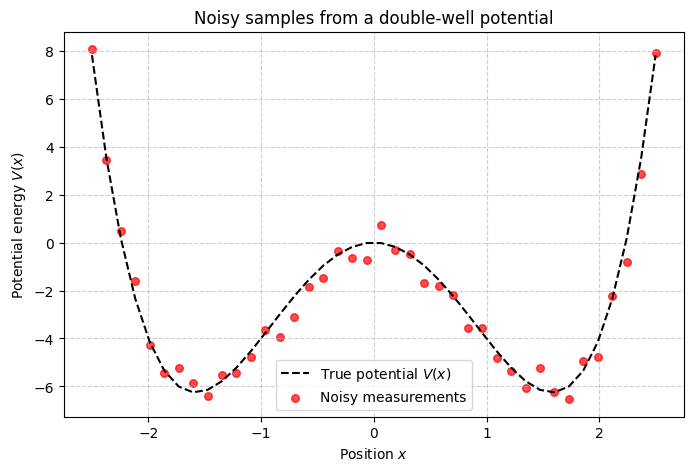

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_potential_surface(n_samples=50, noise_std=0.5, seed=42):
    """
    Double-well potential: V(x) = a*x^4 - b*x^2 with Gaussian noise.
    """
    np.random.seed(seed)
    x = np.linspace(-2.5, 2.5, n_samples).reshape(-1, 1)

    a = 1.0
    b = 5.0
    y_true = a * x**4 - b * x**2
    noise = np.random.normal(0, noise_std, size=y_true.shape)
    y_noisy = y_true + noise

    return x, y_noisy, y_true

# --- Part (a): generate and visualize physics data ---
X_train, y_train, y_true = generate_potential_surface(n_samples=40)

fig, ax = plt.subplots(figsize=(8, 5))

# True potential
ax.plot(X_train, y_true, 'k--', lw=1.5, label='True potential $V(x)$')

# Noisy observations
ax.scatter(X_train, y_train, color='red', s=30, alpha=0.7, label='Noisy measurements')

ax.set_title("Noisy samples from a double-well potential")
ax.set_xlabel("Position $x$")
ax.set_ylabel("Potential energy $V(x)$")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Kernel ridge with scikit-learn

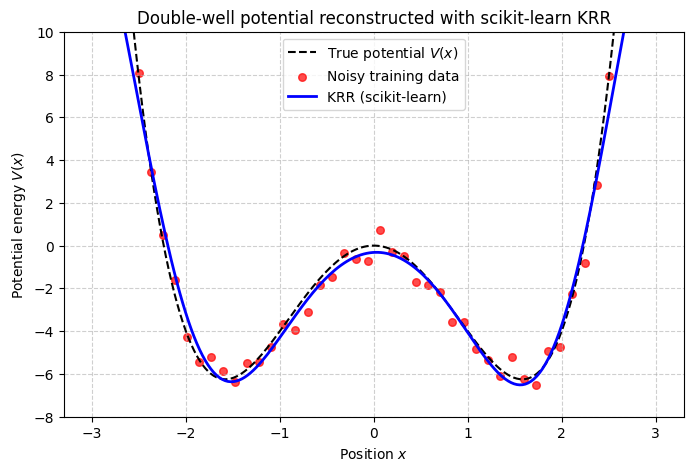

In [ ]:
from sklearn.kernel_ridge import KernelRidge

# Test grid for smooth reconstruction
X_test = np.linspace(-3, 3, 200).reshape(-1, 1)

# --- Part (b): scikit-learn KRR ---
sk_krr = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.01)
sk_krr.fit(X_train, y_train)
y_sk = sk_krr.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 5))

# True potential on test grid (same physics parameters)
a, b = 1.0, 5.0
V_true_test = a * X_test**4 - b * X_test**2

ax.plot(X_test, V_true_test, 'k--', lw=1.5, label='True potential $V(x)$')
ax.scatter(X_train, y_train, color='red', s=30, alpha=0.7, label='Noisy training data')
ax.plot(X_test, y_sk, 'b-', lw=2, label='KRR (scikit-learn)')

ax.set_title("Double-well potential reconstructed with scikit-learn KRR")
ax.set_xlabel("Position $x$")
ax.set_ylabel("Potential energy $V(x)$")
ax.set_ylim(-8, 10)
ax.legend(loc='upper center')
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Custom KRR implementation + comparison and kernel "basis functions"

Scikit-learn / Custom MSE Diff: 0.0000000000


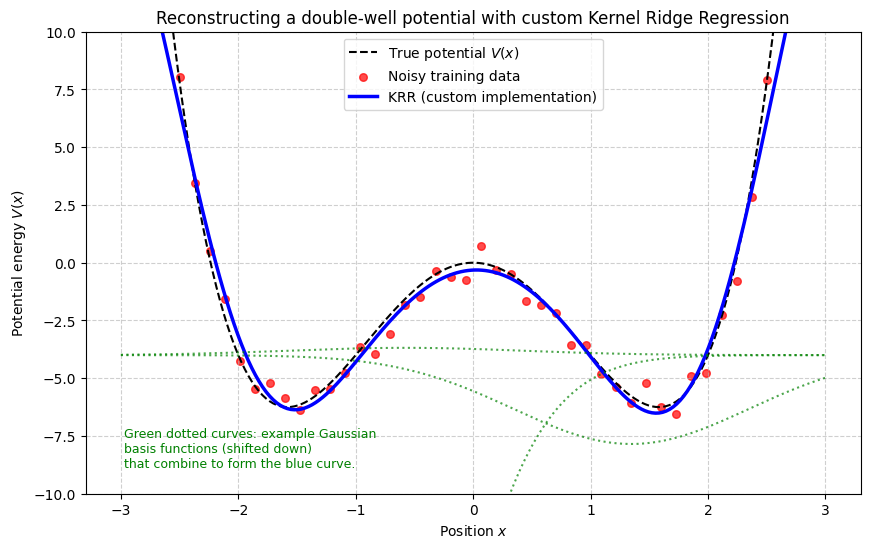

In [ ]:
class KernelRidgePhysics:
    """
    Simple Kernel Ridge Regression (RBF kernel) from scratch.
    """
    def __init__(self, kernel='rbf', gamma=1.0, alpha=0.1):
        self.kernel_type = kernel
        self.gamma = gamma
        self.alpha = alpha
        self.X_train = None
        self.dual_coef_ = None

    def rbf_kernel(self, X1, X2):
        sq_norms1 = np.sum(X1**2, axis=1).reshape(-1, 1)
        sq_norms2 = np.sum(X2**2, axis=1).reshape(1, -1)
        dot_product = np.dot(X1, X2.T)
        dist_sq = sq_norms1 + sq_norms2 - 2 * dot_product
        return np.exp(-self.gamma * dist_sq)

    def fit(self, X, y):
        self.X_train = X
        n_samples = X.shape[0]
        K = self.rbf_kernel(X, X)
        K_reg = K + self.alpha * np.eye(n_samples)
        self.dual_coef_ = np.linalg.solve(K_reg, y)

    def predict(self, X):
        K_trans = self.rbf_kernel(X, self.X_train)
        return np.dot(K_trans, self.dual_coef_)

# --- Part (c): custom KRR ---
krr = KernelRidgePhysics(kernel='rbf', gamma=0.5, alpha=0.01)
krr.fit(X_train, y_train)
y_pred = krr.predict(X_test)

# Compare to scikit-learn
mse_diff = np.mean((y_sk - y_pred)**2)
print(f"Scikit-learn / Custom MSE Diff: {mse_diff:.10f}")

# Visualization including individual kernel “basis functions”
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(X_test, V_true_test, 'k--', lw=1.5, label='True potential $V(x)$')
ax.scatter(X_train, y_train, color='red', s=30, alpha=0.7, label='Noisy training data')
ax.plot(X_test, y_pred, 'b-', lw=2.5, label='KRR (custom implementation)')

# Show a few kernel bumps
indices_to_show = [5, 15, 30]
for idx in indices_to_show:
    x_center = X_train[idx]
    weight = krr.dual_coef_[idx]
    kernel_shape = np.exp(-krr.gamma * (X_test - x_center)**2)
    ax.plot(X_test, kernel_shape * weight - 4, color='green',
            alpha=0.7, linestyle=':', label='_nolegend_')

ax.text(0.05, 0.05,
        "Green dotted curves: example Gaussian\nbasis functions (shifted down)\nthat combine to form the blue curve.",
        transform=ax.transAxes, fontsize=9, color='green',
        verticalalignment='bottom')

ax.set_title("Reconstructing a double-well potential with custom Kernel Ridge Regression")
ax.set_xlabel("Position $x$")
ax.set_ylabel("Potential energy $V(x)$")
ax.set_ylim(-10, 10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()
